In [1]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO

In [2]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [ ]:
# Data can be downloaded from
# https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset/data


data_folder = "../data"
train_folder = f"{data_folder}/train2017"
val_folder = f"{data_folder}/val2017"
annFile = f"{data_folder}/annotations/instances_train2017.json"


train_dataset = datasets.CocoDetection(root=train_folder, annFile=annFile)

loading annotations into memory...
Done (t=2.93s)
creating index...
index created!


In [4]:
coco = COCO(annFile)

# Get all image ids
imgIds = coco.getImgIds()
images_info = coco.loadImgs(imgIds)

# Extract sizes
image_sizes = [(img["width"], img["height"]) for img in tqdm(images_info)]

loading annotations into memory...
Done (t=3.07s)
creating index...
index created!


100%|██████████| 118287/118287 [00:00<00:00, 9205180.94it/s]


In [5]:
size_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
size_df["combined"] = size_df["Width"].astype(str) + "x" + size_df["Height"].astype(str)
dimension_counts = size_df["combined"].value_counts()
dimension_counts_filtered = dimension_counts[dimension_counts > 500]

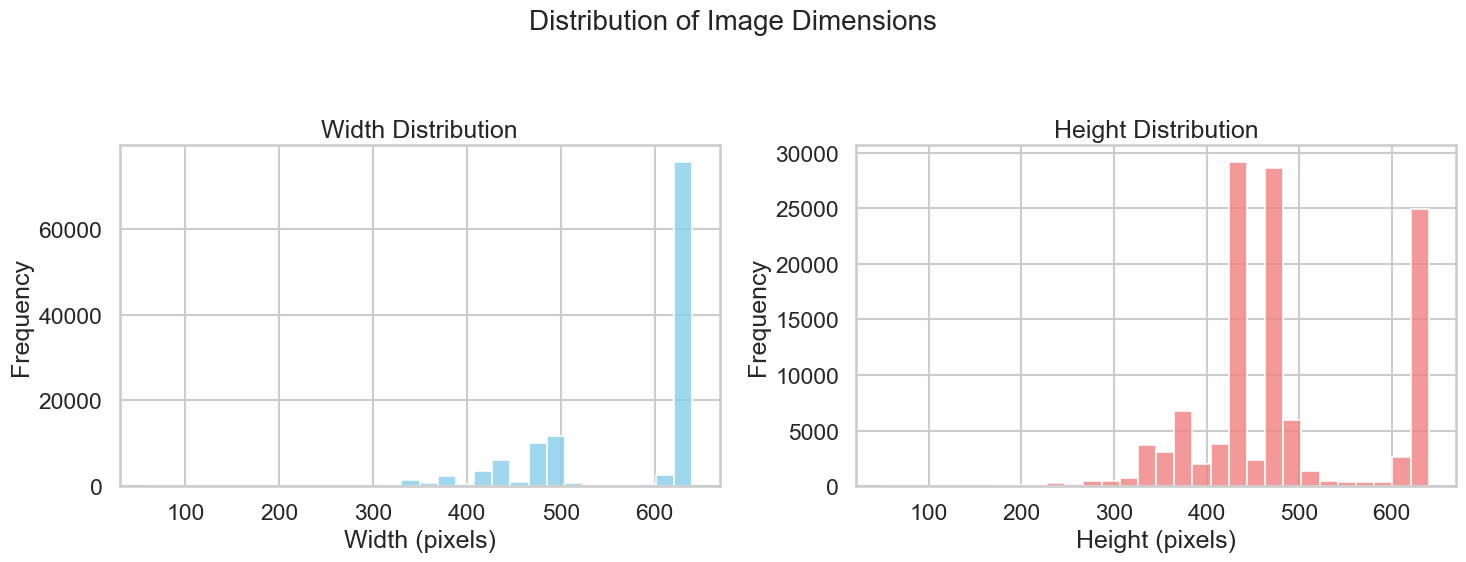


Image Dimension Statistics:
               Width         Height
count  118287.000000  118287.000000
mean      577.712065     484.098895
std        91.884340      97.089573
min        59.000000      51.000000
25%       500.000000     426.000000
50%       640.000000     480.000000
75%       640.000000     513.000000
max       640.000000     640.000000


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Slightly wider figure
fig.suptitle("Distribution of Image Dimensions", fontsize=20)  # Larger title

# Width distribution
sns.histplot(
    size_df["Width"],
    bins=30,
    ax=axes[0],
    color="skyblue",  # Use defined color
    edgecolor="white",  # Add edge color for definition
    alpha=0.8,  # Add some transparency
) 
axes[0].set_title("Width Distribution")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Frequency")

# Height distribution
sns.histplot(
    size_df["Height"],
    bins=30,
    ax=axes[1],
    color="lightcoral",  # Use defined color
    edgecolor="white",  # Add edge color for definition
    alpha=0.8,  # Add some transparency
)
axes[1].set_title("Height Distribution")
axes[1].set_xlabel("Height (pixels)")
axes[1].set_ylabel("Frequency")


# Adjust layout to prevent title overlap and ensure labels fit
plt.tight_layout(rect=[0, 0.03, 1, 0.93])  # Adjusted rect slightly for larger title
plt.show()

# Display basic statistics
print("\nImage Dimension Statistics:")
print(size_df.describe())

/var/folders/29/fzxxbhj56l38j_dynbppz2hr0000gn/T/ipykernel_47602/1814266124.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


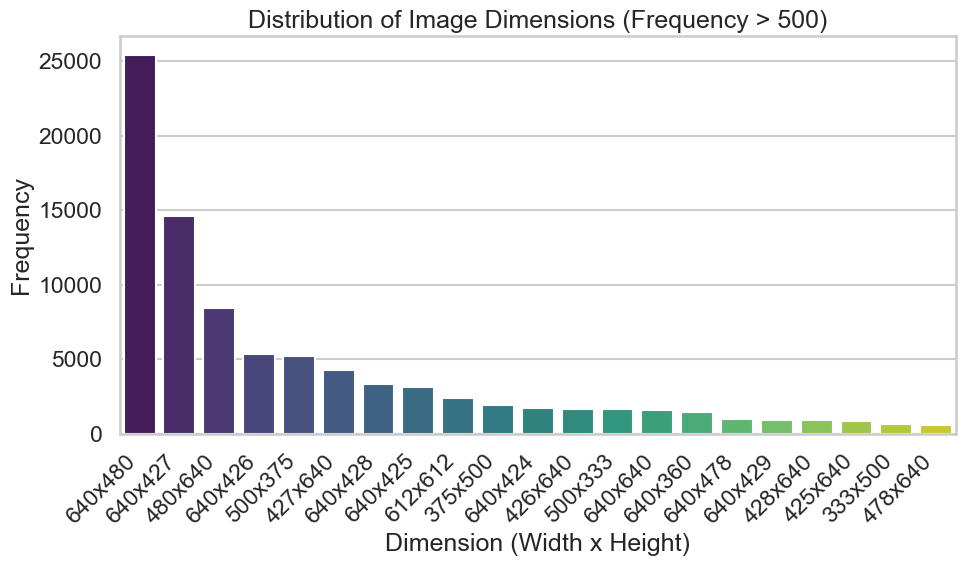

In [7]:
plt.figure(figsize=(10, 6))
# Order bars by frequency
order = dimension_counts_filtered.index
ax = sns.barplot(
    x=dimension_counts_filtered.index,
    y=dimension_counts_filtered.values,
    order=order,
    palette="viridis",
)
plt.title("Distribution of Image Dimensions (Frequency > 500)")
plt.xlabel("Dimension (Width x Height)")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")  # Rotate labels if they overlap
plt.tight_layout()
plt.show()